## Two tests

In [1]:
import A1_provider_prep
import A2_other
import A3_analysis
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely.wkt
from calitp.sql import to_snakecase
from shared_utils import geography_utils, utils
from calitp.storage import get_fs
fs = get_fs()

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", None)

In [3]:
# Get routes
one_dist_routes, multi_dist_routes, all_routes = A2_other.find_multi_district_routes()

In [4]:
# Open original district
districts = A1_provider_prep.get_districts()

## Overlay map against routes as a test
* Try to concat all intersecting routes, then filter if they have a low intersection % in another way.
* The lower the %  of the route covered, the better. That means a lower portion of the route is in a no coverage zone.
* Areas that are covered are white, areas w/o coverage are blue.

Issues I'm coming across
* It takes forever - how to split this so kernel doesn't die in the middle.
* After overlaying, the routes are in a different district then it's supposed to be.

In [5]:
def find_specific_files(phrase_to_find:str):
    """
    Grab a list of files that contain the 
    phrase inputted.
    """
    # Create a list of all the files in my folder
    all_files_in_folder = fs.ls(A1_provider_prep.GCS_FILE_PATH)
    
    # Grab only files with the string "Verizon_no_coverage_"
    my_files = [i for i in all_files_in_folder if phrase_to_find in i]
    
    # String to add to read the Verizon only files
    my_string = "gs://"
    my_files = [my_string + i for i in my_files]
    
    return my_files

In [6]:
# t_mobile_files = find_specific_files("tmobile_no_coverage_d")

In [7]:
def overlay_1_dist_routes(phrase_to_find:str, provider: str):
    """
    Take each district file created from the 
    function `complete_difference_provider_district_level` for a provider
    and overlay the file against the routes that only run in
    one district. Join all the everything together to create
    a full California map for each provider.
    """
    # Open original Caltrans districts shapefile
    # Get rid of A1_provider_prep once I export this
    districts = A1_provider_prep.get_districts()
    
    # Get routes
    one_dist_routes, multi_dist_routes, all_routes = A2_other.find_multi_district_routes()
    
    # Empty gdf to hold results
    routes_overlay_gdf = pd.DataFrame()
    
    # Get a list of files I want
    provider_files_list = find_specific_files(phrase_to_find)
    
    # Loop over every file
    # Put provider_files_list later.
    for file in provider_files_list:
        # Find which district info each file contains. 
        # https://stackoverflow.com/questions/11339210/how-to-get-integer-values-from-a-string-in-python
        district = ''.join(i for i in file if i.isdigit())
        
        # Turn this into an integer
        district = int(district)
        
        # Open file
        district_file = gpd.read_parquet(file)
        
        # Clip routes on the left against the district file
        # overlay_df = gpd.overlay(
        # routes_gdf, provider_gdf, how="intersection", keep_geom_type=False
        overlay_routes = A3_analysis.comparison(one_dist_routes, district_file)
        
        # Add information about which district and which provider
        overlay_routes["Overlay-District"] = f"D-{district}"
        overlay_routes["Overlay-Provider"] = provider
        # Do the 2 columns match? Use this to filter out...
        overlay_routes["do_districts_match"] = overlay_routes["District"] == overlay_routes["Overlay-District"]
        
        # Concat
        routes_overlay_gdf = pd.concat([routes_overlay_gdf, overlay_routes], axis=0)
        
        print(f"Done with District {district}")
    
    utils.geoparquet_gcs_export(routes_overlay_gdf, A1_provider_prep.GCS_FILE_PATH, f"{provider}_overlaid_routes")
    
    return routes_overlay_gdf

In [8]:
# tmobile_test = overlay_1_dist_routes("tmobile_no_coverage_d", "tmobile")

In [9]:
# verizon_test = overlay_1_dist_routes("verizon_no_coverage_d", "verizon")

In [13]:
# att_test = overlay_1_dist_routes("ATT_no_coverage_d", "att")

In [14]:
# Read in AT&T overlaid with unique routes that run in only one district
att_routes = gpd.read_parquet(
    f"{A1_provider_prep.GCS_FILE_PATH}unique_routes_att.parquet"
)

In [15]:
# A lot of false routes...
att_routes.do_districts_match.value_counts()

False    7265
True       19
Name: do_districts_match, dtype: int64

In [19]:
# Keep only false routes
att_routes_false = (att_routes.loc[att_routes.do_districts_match == False]).reset_index(drop = True)

In [10]:
# Read in AT&T overlaid with unique routes
att = dg.read_parquet("ATT.parquet")

<AxesSubplot:>

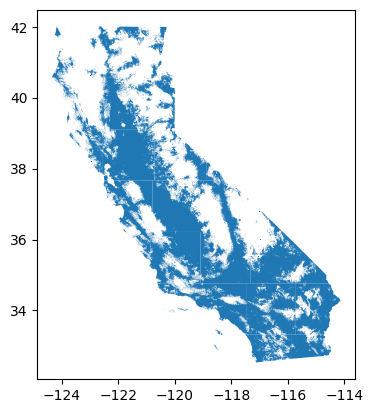

In [38]:
att.compute().plot()

#### MUNI Testing
* Muni only has routes that run in San Francisco and Alameda counties.
* So why are they showing up in D1?

In [31]:
# Here MUNI routes run only in D-4, yet this shows it 100% falls in D1?
att_routes_false.drop(columns = ["geometry"]).loc[att_routes_false.agency == "MUNI"].head(2)

,agency,long_route_name,District,route_length,original_route_length,percentage_route_covered,Overlay-District,Overlay-Provider,do_districts_match
321,MUNI,19TH AVENUE 18160 MUNI,D-4,67649.57,67649.57,100,D-1,att,False
322,MUNI,19TH AVENUE 28 MUNI,D-4,67649.57,67649.57,100,D-1,att,False


In [33]:
# Test with MUNI only - use original geometry
MUNI = all_routes.loc[all_routes["agency"] == "MUNI"]

In [40]:
att_dist_4 = gpd.read_parquet(
    f"{A1_provider_prep.GCS_FILE_PATH}ATT_no_coverage_d4.parquet"
 )

In [41]:
m = att_dist_4.explore(

    tiles="CartoDB positron",
    width=800,
    height=500,
)

In [42]:
m = MUNI.explore("long_route_name",
    m=m,legend = False,
)

In [57]:
# m

In [21]:
# Keep only routes where the district matches
att_routes_true = att_routes.loc[att_routes.do_districts_match == True] 

In [45]:
att_routes_true.agency.value_counts()

San Diego Metropolitan Transit System         5
Yuma County Area Transit                      2
Marin Transit                                 2
Arcata and Mad River Transit System           1
Blue Lake Rancheria                           1
Eureka Transit Service                        1
Humboldt Transit Authority                    1
Mendocino Transit Authority                   1
Tahoe Transportation                          1
Tahoe Truckee Area Regional Transportation    1
Long Beach Transit                            1
Eastern Sierra Transit Authority              1
Mammoth Lakes Transit System                  1
Name: agency, dtype: int64

In [22]:
att_routes_true.drop(columns = ["geometry"]).sample(3)

,agency,long_route_name,District,route_length,original_route_length,percentage_route_covered,Overlay-District,Overlay-Provider,do_districts_match
7,Eastern Sierra Transit Authority,395 Route North 561 Eastern Sierra Transit Authority,D-9,0.00,1140603.05,0,D-9,att,True
266,Eureka Transit Service,Trinidad-Scotia 1 Eureka Transit Service,D-1,0.00,332318.02,0,D-1,att,True
576,Tahoe Truckee Area Regional Transportation,"Squaw Valley, Tahoe City, West Shore 2594 Tahoe Truckee Area Regional Transportation",D-3,0.00,347450.49,0,D-3,att,True


#### District 1 Testing

In [46]:
att_dist_1 = gpd.read_parquet(
    f"{A1_provider_prep.GCS_FILE_PATH}ATT_no_coverage_d1.parquet"
 )

In [51]:
# Filter out District 1 only routes 
dist_1_routes = (one_dist_routes.loc[one_dist_routes["District"] == "D-1"]).reset_index(drop = True)

In [52]:
len(dist_1_routes)

75

In [53]:
n = att_dist_1.explore(

    tiles="CartoDB positron",
    width=800,
    height=500,
)

In [54]:
n = dist_1_routes.explore("long_route_name",
    m=n,legend = False,
)

In [58]:
# n

## Clip sjoin districts with original district file
* Grab all the `tmobile_no_coverage...` parquet files for each district.
* Clip each of those no coverage districts against original district shapefiles.
* Stack all the clipped shapefiles above to create a map for the entire California.

In [ ]:
# Read in T-mobile file
#t_d9 = gpd.read_parquet(
#    f"{A1_provider_prep.GCS_FILE_PATH}tmobile_no_coverage_d9.parquet"
# )

In [ ]:
#t_d6 = gpd.read_parquet(
#    f"{A1_provider_prep.GCS_FILE_PATH}tmobile_no_coverage_d6.parquet"
# )

In [ ]:
# t_d9.plot()

In [ ]:
# d9 = (districts.loc[districts.district == 9]).reset_index()

In [ ]:
# d9.plot()

In [ ]:
# t_d9_clipped = gpd.clip(t_d9, d9, keep_geom_type=False)

In [ ]:
# t_d9_clipped.plot()

In [ ]:
# routes_no_coverage_d9 = A3_analysis.comparison(one_dist_routes, t_d9)

In [ ]:
#routes_no_coverage_d9["district"] = "D9"

In [ ]:
#routes_no_coverage_d10 = A3_analysis.comparison(all_routes, t_d10)

In [ ]:
#routes_no_coverage_d10["district"] = "D10"

In [ ]:
#routes_no_coverage_d6 = A3_analysis.comparison(all_routes, t_d6)

In [ ]:
#routes_no_coverage_d6["district"] = "D6"

In [ ]:
#t_d9_10 = pd.concat([routes_no_coverage_d6, routes_no_coverage_d9, routes_no_coverage_d10])

In [ ]:
#len(t_d9_10)

In [ ]:
# t_d9_10.drop(columns = ["geometry"]).sort_values(["percentage_route_covered","long_route_name", ])

In [ ]:
#value_counts = A2_other.turn_counts_to_df(t_d9_10, "long_route_name")

### T-Mobile Clip `sjoin-difference` results

In [ ]:
def clip_no_coverage_files(phrase_to_find:str, provider:str):
    """
    Take each district file created from the 
    function `complete_difference_provider_district_level` 
    and clip the file against the original
    district shape to get rid of excess edges
    created by the `sjoin`. Join all the districts to create
    a full California map for each provider.
    """
    # Open original Caltrans districts shapefile
    # Get rid of A1_provider_prep
    districts = A1_provider_prep.get_districts()
    
    # Empty gdf to hold results
    california_gdf = pd.DataFrame()
    
    # Get a list of files I want
    provider_files_list = find_specific_files(phrase_to_find)
    
    # Loop over every file
    # Testing with just Bay Area for now 
    # Put provider_files_list later.
    for file in provider_files_list:
        # Find which district info each file contains. 
        # https://stackoverflow.com/questions/11339210/how-to-get-integer-values-from-a-string-in-python
        district_file_path = ''.join(i for i in file if i.isdigit())
        # Turn this into an integer
        district_file_path = int(district_file_path)
        # Take district_file_path and filter out district gdf
        district_of_interest = (districts.loc[districts.district == district_file_path]).reset_index()
        # Open file
        no_coverage_file = gpd.read_parquet(file)
        # Clip no coverage file against original district shape
        file_clipped = gpd.clip(no_coverage_file, district_of_interest, keep_geom_type=False)
        # Concat
        california_gdf = pd.concat([california_gdf, file_clipped], axis=0)
        print(f"Done with District {district_file_path}")
        
    # Export
    # utils.geoparquet_gcs_export(california_gdf, A1_provider_prep.GCS_FILE_PATH, f"{provider}_clipped_og_district_sjoin") 
    
    return california_gdf

In [ ]:
# entire_tmobile = clip_no_coverage_files("tmobile_no_coverage_d", "tmobile")

In [ ]:
entire_tmobile.plot()

In [ ]:
entire_ATT = clip_no_coverage_files("ATT_no_coverage_d", "ATT")

In [ ]:
gpd.read_parquet("ATT.parquet").plot()

In [ ]:
gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/att_all_counties.parquet").plot()

In [ ]:
gpd.read_parquet("gs://calitp-analytics-data/data-analyses/cellular_coverage/ATT_no_coverage_complete_CA.parquet").plot()

In [ ]:
entire_ATT.plot()

#### Test Area

In [ ]:
# Empty gdf
tmobile_gdf = pd.DataFrame()

In [ ]:
for i in t_mobile_files:
    district_file_path = ''.join(district for district in i if district.isdigit())
    district_file_path = int(district_file_path)
    print(district_file_path)

In [ ]:
# Test file path
no_coverage_file_path = 'gs://calitp-analytics-data/data-analyses/cellular_coverage/tmobile_no_coverage_d1.parquet'

In [ ]:
# Find which district a file belongs to 
district_file_path = ''.join(district for district in no_coverage_file_path if district.isdigit())

In [ ]:
# Turn this into an integer
district_file_path = int(district_file_path)
district_file_path

In [ ]:
# Open file path 
no_coverage_file = gpd.read_parquet(no_coverage_file_path)

In [ ]:
# Take district_file_path and filter out district gdf
district_of_interest = (districts.loc[districts.district == district_file_path]).reset_index()

In [ ]:
# Clip no coverage file against original district shape
file_clipped = gpd.clip(no_coverage_file, district_of_interest, keep_geom_type=False)

In [ ]:
file_clipped.plot()

### D4 Verizon Test
* Test district 4 for Verizon

In [ ]:
# Read in Verizon D4
v_d4 = gpd.read_parquet(
   f"{A1_provider_prep.GCS_FILE_PATH}Verizon_no_coverage_d4.parquet"
 )

In [ ]:
# multi_dist_routes_dissolved.drop(columns = ["geometry"])

In [ ]:
v_d4.plot()

In [ ]:
# Get only d4
# d4 = (districts.loc[districts.district == 4]).reset_index()

In [ ]:
# v_d4_clipped = gpd.clip(v_d4, d4, keep_geom_type=False)

In [ ]:
# v_d4_clipped.plot()

In [ ]:
"""n = v_d4_clipped.explore(
    color="red",
    width=800,
    height=400,
)"""

In [ ]:
# Clipped geometry
# n = d4.explore(m=n, legend=False)

In [ ]:
# 10:19 to 10:20
#routes_no_coverage = A2_analysis.comparison(
#        all_routes, v_d4_clipped
#    )

In [ ]:
# routes_no_coverage.drop(columns = ["geometry"])

In [ ]:
# routes_no_coverage_list = routes_no_coverage.long_route_name.unique().tolist()

In [ ]:
# routes_no_coverage_og_geo = all_routes.loc[all_routes.long_route_name.isin(routes_no_coverage_list)]

In [ ]:
# routes_no_coverage_og_geo = routes_no_coverage_og_geo.explore(width=800,
#     height=400, color= "red")

In [ ]:
# routes_no_coverage_og_geo = v_d4_clipped.explore(m=routes_no_coverage_og_geo,)

In [ ]:
# routes_no_coverage_og_geo